In [1]:
# import needed libraries

import pandas as pd
import helper.Utils as Utils
import matplotlib.pyplot as plt
import configure as cf
import re
import pandas as pd
from snowballstemmer import stemmer
import arabicstopwords.arabicstopwords as stp
import pyterrier as pt
from pyterrier.measures import RR, R, Rprec, P, MAP
from train_set_creator import MonoBertTrainSetCreator
from transformers import AutoTokenizer
from mono_bert_train import MonoBertTrainer
from mono_bert_test import MonoBertTester
import statsmodels.stats.multitest
import os

2022-07-29 12:14:04.947077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 12:14:04.947122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

if not pt.started():
    print("Enabling PRF in pyterier")
    # In this lab, we need to specify that we start PyTerrier with PRF enabled
    pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

Enabling PRF in pyterier
PyTerrier 0.6.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


Before indexing our data we need to do the following processing steps:


1.   **Remove stopwords.**
2.   **Normalization.**
3.   **Stemming.**

In [3]:

def clean(text):

  '''
  Clean input text form urls, handles, tabs, line jumps, and extra white spaces
  '''
  text = re.sub(r"http\S+", " ", text)  # remove urls
  text = re.sub(r"RT ", " ", text)  # remove rt
  text = re.sub(r"@[\w]*", " ", text)  # remove handles
  # text = re.sub(r"[\.\,\#_\|\:\?\?\/\=]", " ", text)# remove special characters
  text = re.sub(r"\t", " ", text)  # remove tabs
  text = re.sub(r"\n", " ", text)  # remove line jump
  text = re.sub(r"\s+", " ", text)  # remove extra white space
  text = text.strip()
  return text
  
#removing stop sords function
def remove_stop_words(sentence):
  terms=[]
  stopWords= set(stp.stopwords_list())
  for term in sentence.split() : 
      if term not in stopWords :
          terms.append(term)
  return " ".join(terms)

#a function to normalize the tweets
def normalize(text):
  text = re.sub("[إأٱآا]", "ا", text)
  text = re.sub("ى", "ي", text)
  text = re.sub("ؤ", "ء", text)
  text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", text)
  return(text)


def stem(sentence):
    return " ".join([ar_stemmer.stemWord(i) for i in sentence.split()])


def preprocess(sentence):
  # apply preprocessing steps on the given sentence
  sentence = Utils.clean(sentence)
  sentence = Utils.remove_emoji_smileys(sentence)
  sentence =normalize(sentence)
  sentence =remove_stop_words(sentence)
  sentence =stem(sentence)
  return sentence

#define the stemming function
ar_stemmer = stemmer("arabic")
ar_stemmer 

In [4]:

# define some constants.
is_index_built= False
DECIMAL_ROUND = 5
pos_label = 1.0
neg_label = 0.0
RANK = cf.RANK
SCORE = cf.SCORE
TWEET_ID_COLUMN = cf.TWEET_ID_COLUMN
TWEET_TEXT_COLUMN = cf.TWEET_TEXT_COLUMN
VCLAIM_ID = cf.VCLAIM_ID
VCLAIM = cf.VCLAIM
TITLE = cf.TITLE 
LABEL = cf.LABEL


QUERY = cf.QUERY
QID = cf.QID
DOC_NO = cf.DOC_NO
DOCID = cf.DOCID

index_path = "./indexes/ar-clef-2021-index-multi-field/data.properties"
qrels_file=cf.AR_2021_QRElS_FILE
claims_file = cf.AR_2021_VCLAIMS_FILE
evaluation_save_path = "./data/ar_clef2021_evaluation.xlsx"

raw_dev_query = cf.AR_2021_DEV_QUERIES_PATH
expanded_dev_query = cf.AR_2021_URL_CLEANED_DEV_QUERIES

dev_query_path = expanded_dev_query
train_query_path = cf.AR_2021_URL_CLEANED_TRAIN_QUERIES
test_query_path = cf.AR_2021_URL_CLEANED_TEST_QUERIES 
eval_metrics=["map",MAP@5, P@1, RR, Rprec, R@5, R@10, R@20, R@50, RR@5]

dev_bm25_run = "./data/runs/bm25_dev_query_ar_clef_2021.tsv"
train_bm25_run = "./data/runs/bm25_train_query_ar_clef_2021.tsv"
test_bm25_run = "./data/runs/bm25_test_query_ar_clef_2021.tsv"
mono_bert_train_vclaim_set = "./data/CLEF_2021/Arabic/train_sets/2021_mono_bert_train_set-vclaim-only--ar.xlsx"
mono_bert_train_title_set = "./data/CLEF_2021/Arabic/train_sets/2021_mono_bert_train_set-title-only-ar.xlsx"
mono_bert_train_both_vclaim_and_title_set = "./data/CLEF_2021/Arabic/train_sets/2021_mono_bert_train_set-both_vclaim_and_title.xlsx"
                                
random_seeds = [61168821, 129995678, 22612812, 146764631, 21228945, 94412880, 204110176, 6155814, 187372311, 117623077,]


NUM_CLASSES = 2
ONE_LAYER = 1
TWO_LAYERS = 2



In [5]:
# Read verified claims file
df_claim = Utils.read_file(claims_file)
df_claim[VCLAIM_ID]= df_claim[VCLAIM_ID].astype(str)
df_claim.set_index(VCLAIM_ID, inplace=True)
df_claim

,vclaim,title
vclaim_id,,
vclaim-0000,العاهل المغربي يتلقى الجرعة الاولى من لقاح كورونا,العاهل المغربي يتلقى الجرعة الأولى من اللقاح ا...
vclaim-0001,نقل اسواق الموسكي والعتبة والفجالة إلى شرق الق...,نقل أسواق الموسكي والعتبة والفجالة والأزهر إلى...
vclaim-0002,جائحة كورونا ليست كارثة صحية ولا نرى ذلك في ال...,لم تنشر جامعة جون هوبكنز هذا التقرير بخصوص جائ...
vclaim-0003,لقاح كورونا غير امن وبشهاده اطباء من دول اروبيه,لقاح كورونا غير آمن وبشهادة أطباء من دول أوروب...
vclaim-0004,احتمال اجراء امتحانات الصفين الاول والثاني الث...,هذه الصورة المتداولة حول امتحانات مصر مفبركة -...
...,...,...
vclaim-9995,رفض الرئيس أيزنهاور فكرة العروض العسكرية ، قائ...,"هل رفض دوايت أيزنهاور فكرة العروض العسكرية ""ال..."
vclaim-9996,شكوى FTC / DOJ / DOT.,تحذير من الفيروسات: تنزيل شكوى FTC / DOJ / DOT
vclaim-9997,"تم العثور على فتاة مهاجرة مع ""20 نوعا من السائ...",هل تم العثور على فتاة مهاجرة وبها 20 نوعًا من ...


## Load QRELs file

In [6]:
def load_qrels(qrels_file):
    df_qrels = pd.read_csv(qrels_file, sep="\t", names=["qid", "Q0", "docno", LABEL])
    df_qrels["qid"]=df_qrels["qid"].astype(str)
    df_qrels["docno"]=df_qrels["docno"].astype(str)
    return df_qrels

df_qrels = load_qrels(qrels_file)
df_qrels

,qid,Q0,docno,label
0,tweet-ar-000,0,vclaim-2264,1
1,tweet-ar-001,0,vclaim-2266,1
2,tweet-ar-002,0,vclaim-2267,1
3,tweet-ar-003,0,vclaim-2271,1
4,tweet-ar-004,0,vclaim-2270,1
...,...,...,...,...
1034,tweet-529,0,vclaim-0237,1
1035,tweet-068,0,vclaim-0171,1
1036,tweet-742,0,vclaim-1109,1
1037,tweet-757,0,vclaim-0434,1


## Create multi-fields index

In [7]:
def load_index(index_path):
    try:
            # first load the index
        multi_field_index = pt.IndexFactory.of(index_path)
        # call getCollectionStatistics() to check the stats
        print(multi_field_index.getCollectionStatistics().toString())
        print("Index has been loaded successfully")
        return multi_field_index
    except Exception as e:
        print('Cannot load the index, check exception details {}'.format(e))
        return []


multi_field_index = load_index(index_path=index_path)



Number of documents: 30329
Number of terms: 36535
Number of postings: 497017
Number of fields: 2
Number of tokens: 652148
Field names: [text, title]
Positions:   false

Index has been loaded successfully


## Searching function


In [8]:
def clean_query_for_search(query_path, data_column="cleaned"):

    print("Cleaning queries and applying preprocessing steps")
    df_query = Utils.read_file(query_path)
    df_query[QUERY] =df_query[data_column].apply(Utils.remove_punctuation)
    df_query[QUERY] = df_query[QUERY].apply(preprocess)
    df_query[QID] = df_query[TWEET_ID_COLUMN].astype(str)
    df_query = df_query[[QID, QUERY]]
    print("Done with cleaning!")
    return df_query
    
def search_and_evaluate(query_path, run_save_path, retrieval_model="BM25", evaluation_path="",
                        data_column='cleaned', depth=100, method_name="BM25"):
    
    df_query = clean_query_for_search(query_path, data_column=data_column)
    # intialize retrieval model to get the top k (depth) potentially relevant documents
    retr = pt.BatchRetrieve(multi_field_index, controls = {"wmodel": retrieval_model},num_results=depth)
    print("Searching for the queries .....")
    # retrieve potentially relevant documents for each query in queries file
    retr_res = retr.transform(df_query)
    # save the run in trec format
    retr_res.to_csv(run_save_path, header=False, index=False, sep='\t')


    # Evaluate the performance
    print("Perfomring evaluation ......")
    retr_eval = pt.Utils.evaluate(retr_res, df_qrels[["qid", "docno", LABEL]],metrics=eval_metrics)
    retr_eval.update({"name": method_name})
    retr_eval.update({"depth": depth})
    retr_eval = pd.DataFrame([retr_eval])
    retr_eval = retr_eval.round(DECIMAL_ROUND)

    # save evaluation results
    if evaluation_path != "":
        if not os.path.isfile(evaluation_path): # if file is not exist, create a new one
            retr_eval.to_excel(evaluation_path, index=False)
        else: # it is already exist, append current evaluation to it
            df_eval = Utils.read_file(evaluation_path)
            df_eval = df_eval.append(retr_eval, ignore_index=True)
            df_eval.to_excel(evaluation_path, index=False)
    
    
    
    print("Done searching and evaluation ")
    return retr_res, retr_eval
    

### Test lexical retrieval models before and after applying the preprocessing steps (expanding the tweet) on the dev set

In [9]:
# 1. Read test queries

df_dev_query  = clean_query_for_search(raw_dev_query, data_column=TWEET_TEXT_COLUMN)
df_dev_query_after_preprocessing = clean_query_for_search(expanded_dev_query, data_column="cleaned")

# retrieva models
depth = 100 
JM = pt.BatchRetrieve(multi_field_index,wmodel="Hiemstra_LM",controls ={"c":0.05},num_results=depth)
bm25_retr = pt.BatchRetrieve(multi_field_index, controls = {"wmodel": "BM25", "c" : 0.75, "bm25.k_1": 0.75, "bm25.k_3": 0.75},num_results=depth)
DPH = pt.BatchRetrieve(multi_field_index,wmodel="DPH", num_results=depth)
DLH = pt.BatchRetrieve(multi_field_index,wmodel="DLH", num_results=depth)
DFR_BM25 = pt.BatchRetrieve(multi_field_index,wmodel="DFR_BM25", num_results=depth)
rm3_pipe = bm25_retr >> pt.rewrite.RM3(multi_field_index,fb_terms=10, fb_docs=3) >> bm25_retr

retrieval_models = [JM, bm25_retr, DPH, DLH, DFR_BM25, rm3_pipe]
retreival_model_names =  ["JM", "BM25", "DPH", "DLH", "DFR_BM25", "rm3_pipe"]

df_eval_all = pd.DataFrame()
for i in range(len(retrieval_models)):
    retrieval_model = retrieval_models[i]
    retrieval_model_name = retreival_model_names[i]

    retrieval_list = retrieval_model.transform(df_dev_query)
    retrieval_list_after_preprocessing= retrieval_model.transform(df_dev_query_after_preprocessing)


    df_eval = pt.Experiment([retrieval_list, retrieval_list_after_preprocessing],
                df_dev_query,
                df_qrels[["qid", "docno", LABEL]],
                eval_metrics=eval_metrics,
                names=[retrieval_model_name, retrieval_model_name+"+PreP"],
                baseline=0)
    df_eval_all = df_eval_all.append(df_eval, ignore_index=True)



df_eval_all.to_excel("./data/ar_classic_retrieval_with_preprocessing_on_dev.xlsx", index=False)
df_eval_all

Cleaning queries and applying preprocessing steps
Done with cleaning!
Cleaning queries and applying preprocessing steps
Done with cleaning!


,name,map,Rprec,RR,P@1,R@5,R@10,R@20,R@50,AP@5,...,R@20 p-value,R@50 +,R@50 -,R@50 p-value,AP@5 +,AP@5 -,AP@5 p-value,RR@5 +,RR@5 -,RR@5 p-value
0,JM,0.817434,0.776471,0.839100,0.800000,0.866667,0.878431,0.890196,0.943137,0.812157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JM+PreP,0.830642,0.782353,0.842668,0.800000,0.886275,0.890196,0.901961,0.949020,0.826863,...,0.158524,1.0,0.0,0.320183,4.0,2.0,0.144243,1.0,0.0,0.320183
2,BM25,0.829863,0.788235,0.844753,0.800000,0.890196,0.890196,0.901961,0.954902,0.826732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BM25+PreP,0.850639,0.811765,0.860182,0.823529,0.901961,0.901961,0.913725,0.960784,0.848301,...,0.158524,1.0,0.0,0.320183,3.0,0.0,0.101347,2.0,0.0,0.158524
4,DPH,0.804322,0.758824,0.820088,0.776471,0.856863,0.884314,0.913725,0.937255,0.797712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,DPH+PreP,0.825783,0.782353,0.841273,0.800000,0.880392,0.901961,0.913725,0.937255,0.820261,...,1.000000,2.0,1.0,1.000000,4.0,0.0,0.098047,2.0,0.0,0.158524
6,DLH,0.818932,0.782353,0.834336,0.800000,0.860784,0.884314,0.901961,0.943137,0.813007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DLH+PreP,0.839428,0.800000,0.848971,0.811765,0.890196,0.901961,0.901961,0.949020,0.836536,...,1.000000,1.0,0.0,0.320183,4.0,0.0,0.089780,2.0,0.0,0.181258
8,DFR_BM25,0.806798,0.764706,0.820071,0.776471,0.856863,0.872549,0.907843,0.943137,0.799085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,DFR_BM25+PreP,0.825922,0.770588,0.840628,0.800000,0.886275,0.890196,0.901961,0.949020,0.821634,...,0.657393,1.0,0.0,0.320183,3.0,1.0,0.132692,3.0,0.0,0.102793


## Create training data for mono BERT

In [10]:
def create_train_set(mono_train_set_creator, train_query_path, train_bm25_run_path, bm25_evaluation_save_path,train_set_save_path, 
                    search_depth=100, query_column="cleaned", retrieval_model="BM25", depth_of_random=20,
                    what_to_add=cf.VCLAIM_AND_TITLE,  add_similarity=False, lang="ar"):


   # 1- create run for both dev and train queries
    print("Make runs and evaluation")
    mono_train_set_creator.search_and_evaluate(query_path=train_query_path, evaluation_path=bm25_evaluation_save_path, 
                        retrieval_model=retrieval_model, run_save_path=train_bm25_run_path, 
                        depth=search_depth, method_name="bm25_train+dev", data_column=query_column, lang=lang)
    print("Done with runs and evaluation")

    # 2- create the training set
    print("Creating train set")
    mono_train_set_creator.create_train_pairs(train_query_path, train_bm25_run_path, train_set_save_path, 
                            query_column="cleaned", what_to_add=what_to_add, 
                            depth_of_random=depth_of_random, add_similarity=add_similarity,)
    print("Done creating train set")

In [11]:
mono_bert_dev_set_depth_20=  "./data/CLEF_2021/Arabic/dev_sets/ar-clef2021-mono_bert_dev_set_top_20.tsv"
mono_bert_dev_set_depth_30= "./data/CLEF_2021/Arabic/dev_sets/ar-clef2021-mono_bert_dev_set_top_30.tsv"

mono_bert_train_set = mono_bert_train_both_vclaim_and_title_set

# depth from which negative pairs will be randomly selected from top k documents retrieved from a retrieval model
RANDOM_DEPTH = 20 # RANDOM_DEPTH_FOR_SELECTING_NEGATIVE_DOCUMENTS
search_depth = 100

mono_train_set_creator = MonoBertTrainSetCreator(qrels_file, claims_file, index_path, eval_metrics)
mono_bert_trainer = MonoBertTrainer(train_query_path, dev_query_path, qrels_path=qrels_file,)
mono_bert_tester = MonoBertTester(qrels_path=qrels_file,
                                evaluation_save_path=evaluation_save_path)


Number of documents: 30329
Number of terms: 36535
Number of postings: 497017
Number of fields: 2
Number of tokens: 652148
Field names: [text, title]
Positions:   false

Index has been loaded successfully


In [13]:

df_train_set_both = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_both_vclaim_and_title_set, 
                    search_depth=search_depth, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.VCLAIM_AND_TITLE, add_similarity=False,)

df_train_set_title_only = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_title_set, 
                    search_depth=search_depth, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.TITLE_ONLY, add_similarity=False,)

df_train_set_vclaim = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_vclaim_set, 
                    search_depth=search_depth, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.VCLAIM_ONLY, add_similarity=False,)


df_train_set_both

Number of documents: 30329
Number of terms: 36535
Number of postings: 497017
Number of fields: 2
Number of tokens: 652148
Field names: [text, title]
Positions:   false

Index has been loaded successfully
Make runs and evaluation
Cleaning queries and applying preprocessing steps
Applying normalization, stemming and stop word removal for Arabic
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating train set
Processing tweet number 0 with tweet id tweet-ar-003 
Processing tweet number 100 with tweet id tweet-ar-167 
Processing tweet number 200 with tweet id tweet-ar-347 
Processing tweet number 300 with tweet id tweet-ar-508 
Processing tweet number 400 with tweet id tweet-ar-670 
Processing tweet number 500 with tweet id tweet-ar-848 
Done creating train set
Make runs and evaluation
Cleaning queries and applying preprocessing steps
Applying normalization, stemming and stop word removal for Arabic
Done with cleaning!
Sear

## Create dev and test sets for mono BERT

In [17]:
def create_test_set(mono_train_set_creator, query_path, bm25_run_path, bm25_evaluation_save_path, pairs_save_path, 
                    search_depth=100, query_column="cleaned", retrieval_model="BM25", lang="ar"):


   # 1- create run for both dev and train queries
    print("Make runs and evaluation for depth ", search_depth)
    mono_train_set_creator.search_and_evaluate(query_path=query_path, evaluation_path=bm25_evaluation_save_path, 
                        retrieval_model=retrieval_model, run_save_path=bm25_run_path, 
                        depth=search_depth, method_name="bm25_dev-or-test", data_column=query_column, lang=lang)
    print("Done with runs and evaluation")

    # 2- create the training set
    print("Creating test/dev set for mono BERT from queries path: ", query_path)
    mono_train_set_creator.create_test_pairs(query_path, bm25_run_path, query_column="cleaned", 
                    pairs_save_path=pairs_save_path,)
    print("Done creating test set for mono BERT")
    
    return  

## Create dev sets from top k retrieved documents by bm25

In [18]:
depths = [10, 20, 30, 50, 100,]
mono_train_set_creator = MonoBertTrainSetCreator(qrels_file, claims_file, index_path, eval_metrics)

for i in range(len(depths)):
    depth = depths[i]
    bm25_run_path =  "./data/runs/bm25_dev_query_ar_clef_2021_depth_" + str(depth) + ".tsv"
    mono_bert_dev_set = "./data/CLEF_2021/Arabic/dev_sets/ar-clef2021-mono_bert_dev_set_top_"  + str(depth) + ".tsv"

    create_test_set(mono_train_set_creator, dev_query_path, bm25_run_path, 
                    bm25_evaluation_save_path="", pairs_save_path=mono_bert_dev_set, 
                    search_depth=depth, query_column="cleaned", retrieval_model="BM25", lang="ar")


Number of documents: 30329
Number of terms: 36535
Number of postings: 497017
Number of fields: 2
Number of tokens: 652148
Field names: [text, title]
Positions:   false

Index has been loaded successfully
Make runs and evaluation for depth  10
Cleaning queries and applying preprocessing steps
Applying normalization, stemming and stop word removal for Arabic
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/Arabic/url_cleaned_dev_queries.xlsx
Done creating test set for mono BERT
Make runs and evaluation for depth  20
Cleaning queries and applying preprocessing steps
Applying normalization, stemming and stop word removal for Arabic
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/Arabic/url_cleaned_dev_queries.xlsx
1000 

------------------------------------------------------------------------------------
## Create test sets from top k documents retrieved by bm25
------------------------------------------------------------------------------------

In [17]:
depths = [10, 20, 30, 50, 100,]
mono_train_set_creator = MonoBertTrainSetCreator(qrels_file, claims_file, index_path, eval_metrics)

for i in range(len(depths)):
    depth = depths[i]
    bm25_run_path =  "./data/runs/bm25_test_query_ar_clef_2021_depth_" + str(depth) + ".tsv"
    mono_bert_test_set_path = "./data/CLEF_2021/Arabic/dev_sets/2021-mono_bert_test_set_top_"  + str(depth) + ".tsv"

    create_test_set(mono_train_set_creator, test_query_path, bm25_run_path, 
                    bm25_evaluation_save_path="", pairs_save_path=mono_bert_test_set_path, 
                    search_depth=depth, query_column="cleaned", retrieval_model="BM25", lang="ar")

Number of documents: 30329
Number of terms: 36535
Number of postings: 497017
Number of fields: 2
Number of tokens: 652148
Field names: [text, title]
Positions:   false

Index has been loaded successfully
Make runs and evaluation for depth  10
Cleaning queries and applying preprocessing steps
Applying normalization, stemming and stop word removal for Arabic
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/Arabic/url_cleaned_test_queries.xlsx
1000  rows have been created so far 
2000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  20
Cleaning queries and applying preprocessing steps
Applying normalization, stemming and stop word removal for Arabic
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT fro

## Get the maximum length needed to tokenize a pair of query and document in the training set

Maximum length of a tokenized example is :  474
Sentence Lengths: 


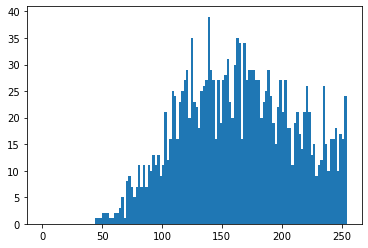

Number of documents that are bigger than max legnth 
544


In [13]:
# measure the maximum length needed to tokenize a triplet
def get_pairs_max_length(data_path, tokenizer, max_length):
    df = Utils.read_file(data_path)
    lengths = []
    maxl = 0
    for i, row in df.iterrows():
        query = row[TWEET_TEXT_COLUMN]
        document = row[VCLAIM]
        row_len = len(tokenizer.tokenize(query)) +len(tokenizer.tokenize(document))
        lengths.append(row_len)
        maxl = max(maxl, row_len)
    print("Maximum length of a tokenized example is : ", maxl)
    print("Sentence Lengths: ")
    plt.hist(lengths ,bins=range(0,256,2))
    plt.show()

    print("Number of documents that are bigger than max legnth ")
    print(sum([length > max_length for length in lengths]))
    
    return 

BERT = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(BERT)
get_pairs_max_length(mono_bert_train_both_vclaim_and_title_set ,tokenizer, max_length=255)

## Tuning the model on dev set to figure out the best depth of the initial retrieved list

In [13]:
depth_evaluation_file = "./data/evaluation/AR-2021-mono-bert-depth-evaluation-on-dev-set.xlsx"
bert_models = [ {"model_path":"aubmindlab/bert-base-arabertv02",
                "model_name": "AraBERT",
                "learning_rate": 2e-5,
                "num_of_epoch": 4,
                "dropout": 0.3},
                ]
 
seed = random_seeds[0]

for i in range(len(bert_models)):
    bert_model = bert_models[i]["model_path"]
    model_name =  bert_models[i]["model_name"]
    learning_rate =  bert_models[i]["learning_rate"]
    num_of_epoch =  bert_models[i]["num_of_epoch"]
    dropout =  bert_models[i]["dropout"]
    hp = { # hyper parameters
    "model_name": bert_model,
    "name": model_name,
    "model_save_path": "./data/saved_models/AR-clef2021-"+model_name+"_mono_trained_model-seed-"+ str(seed)+".bin",
    "model_training_log": "./data/bert_evaluation/AR-clef2021-mono_"+model_name+"_training_log-seed-"+ str(seed)+".xlsx",
    "batch_size": 32,
    "num_of_epochs": num_of_epoch,
    "learning_rate" : learning_rate,
    "dropout": dropout,
    "seeds": seed,
    "max_len": 256,
    "curricula_type": 0,
    "end_of_curriculum": [0],
    "num_of_layers": ONE_LAYER,
    "is_output_probability": False, # if false, put loss_function = mono_loss, otherwise put loss_function=CrossEntropy
    "loss_function": "mono_loss"}
    
    _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                    mono_bert_train_set, mono_bert_dev_set_depth_30, hp["model_name"], apply_cleaning=False, seeds=hp["seeds"],
                    trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                    batch_size=hp["batch_size"], epochs=hp["num_of_epochs"], learning_rates=hp["learning_rate"],
                    is_output_probability=hp["is_output_probability"], end_of_curriculums=hp["end_of_curriculum"],
                    curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                    classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)

    # store the best hyperparameters
    hp["num_of_epochs"]= best_num_of_epochs
    hp["learning_rate"]= best_learning_rate
    hp["end_of_curriculum"]= best_end_of_curriculum
    hp["dropout"]= best_dropout

    # measure the performance on the test set
    depths = [10, 20, 30, 50, 100,]
    for k in range(len(depths)):
        depth = depths[k]
        hp["test_depth"] = depth

        mono_bert_dev_set = "./data/CLEF_2021/Arabic/dev_sets/ar-clef2021-mono_bert_dev_set_top_"  + str(depth) + ".tsv"
        run_name = "AR-2021-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_dev-data-depth_" +str(depth)+".tsv"
        hp["reranked_data_path"] = "./data/runs/" + run_name
        hp["trec_run_path"] = "./data/runs/trec_eval/AR2021/"+ run_name

        mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_dev_set, 
                        hp["reranked_data_path"],  depth_evaluation_file, max_len=hp["max_len"], batch_size=hp["batch_size"],
                        dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                        hyper_parameters=hp,  classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                        what_to_test=cf.VCLAIM_AND_TITLE)

Running Testing ...
Done with re-ranking tweets 
Output is saved into  ./data/runs/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_10.tsv
Trec run is saved into  ./data/runs/trec_eval/AR2021/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_10.tsv
Running Testing ...
Done with re-ranking tweets 
Output is saved into  ./data/runs/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_20.tsv
Trec run is saved into  ./data/runs/trec_eval/AR2021/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_20.tsv
Running Testing ...
Done with re-ranking tweets 
Output is saved into  ./data/runs/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_30.tsv
Trec run is saved into  ./data/runs/trec_eval/AR2021/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_30.tsv
Running Testing ...
  Batch   100  of    133.    Elapsed: 0:00:51.
Done with re-ranking tweets 
Output is saved into  ./data/runs/AR-2021-mono_AraBERT-seed-61168821_rerankded_dev-data-depth_

## Start training sentence BERT models

In [ ]:
bert_models = [ 
                {"model_path":"asafaya/bert-base-arabic",
                "model_name": "Arabic_BERT"},
                {"model_path":"lanwuwei/GigaBERT-v3-Arabic-and-English",
                "model_name": "GigaBERT-v3"},
                {"model_path":"UBC-NLP/MARBERT",
                "model_name": "MARBERT"},
                {"model_path":"aubmindlab/bert-base-arabertv02",
                "model_name": "AraBERT"},
                {"model_path":"qarib/bert-base-qarib",
                "model_name": "QARiB"},
                {"model_path":"kuisailab/albert-base-arabic",
                "model_name": "Arabic-ALBERT"},
                ]
 

num_rand_seeds  = 5
seeds = random_seeds[:num_rand_seeds]
for i in range(len(bert_models)):

    seed = seeds[l]
    bert_model = bert_models[i]["model_path"]
    model_name =bert_models[i]["model_name"]
    print("---------- training for model : --------", model_name)
    hp = { # hyper parameters

    "model_name": bert_model,
    "name": model_name +"-seed-"+ str(seed),
    "model_save_path": "./data/saved_models/AR-clef2021-"+model_name+"_mono_trained_model-seed-"+ str(seed)+".bin",
    "model_training_log": "./data/bert_evaluation/AR-clef2021-mono_"+model_name+"_training_log-seed-"+ str(seed)+".xlsx",
    "batch_size": 32,
    "test_depth": 30,
    "num_of_epochs": [3, 4, 5], 
    "learning_rate" : [2e-5, 3e-5],
    "dropout": [0.3, 0.4,], 
    "seeds": [seed],
    "max_len": 256,
    "curricula_type": 0,
    "end_of_curriculum": [0],
    "num_of_layers": ONE_LAYER,
    "is_output_probability": False, # if false, put loss_function = mono_loss, otherwise put loss_function=CrossEntropy
    "loss_function": "mono_loss"}
   


    _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_30, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)



    # store the best hyperparameters
    hp["num_of_epochs"]= best_num_of_epochs
    hp["learning_rate"]= best_learning_rate
    hp["end_of_curriculum"]= best_end_of_curriculum
    hp["dropout"]= best_dropout


    # measure the performance on the test set
    depths = [30,]
    for k in range(len(depths)):
        depth = depths[k]
        hp["test_depth"] = depth

        mono_bert_test_set_path = "./data/CLEF_2021/Arabic/dev_sets/2021-mono_bert_test_set_top_"  + str(depth) + ".tsv"
        run_name = "AR-2021-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-depth_" +str(depth)+".tsv"
        hp["reranked_data_path"] = "./data/runs/" + run_name
        hp["trec_run_path"] = "./data/runs/trec_eval/AR2021/"+ run_name

        mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_test_set_path, 
                        hp["reranked_data_path"],  evaluation_save_path, max_len=hp["max_len"], batch_size=hp["batch_size"],
                        dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                        hyper_parameters=hp,  classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                        what_to_test=cf.VCLAIM_AND_TITLE)


    # then we get the best hyper parameters values
    # and we can run the training with different random seeds
    l = 1
    while l < num_rand_seeds:
        seed = seeds[l]
        l = l + 1
        hp["name"] = model_name +"-seed-"+ str(seed)
        hp["model_save_path"]=  "./data/saved_models/AR-clef2021-"+model_name+"_mono_trained_model-seed-"+ str(seed)+".bin"
        hp["model_training_log"]="./data/bert_evaluation/AR-clef2021-mono_"+model_name+"_training_log-seed-"+ str(seed)+".xlsx"
        hp["learning_rate"]= [best_learning_rate]
        hp["num_of_epochs"]= [best_num_of_epochs]
        hp["end_of_curriculum"]= [best_end_of_curriculum]
        hp["dropout"]= [best_dropout]
        hp["seeds"] = [seed]


        _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_30, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)


        # store the best hyperparameters
        hp["num_of_epochs"]= best_num_of_epochs
        hp["learning_rate"]= best_learning_rate
        hp["end_of_curriculum"]= best_end_of_curriculum
        hp["dropout"]= best_dropout


        # measure the performance on the test set
        depths = [30,]
        for k in range(len(depths)):
            depth = depths[k]
            hp["test_depth"] = depth

            mono_bert_test_set_path = "./data/CLEF_2021/Arabic/dev_sets/2021-mono_bert_test_set_top_"  + str(depth) + ".tsv"
            run_name = "AR-2021-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-depth_" +str(depth)+".tsv"
            hp["reranked_data_path"] = "./data/runs/" + run_name
            hp["trec_run_path"] = "./data/runs/trec_eval/AR2021/"+ run_name

            mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_test_set_path, 
                        hp["reranked_data_path"],  evaluation_save_path, max_len=hp["max_len"], batch_size=hp["batch_size"],
                        dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                        hyper_parameters=hp,  classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                        what_to_test=cf.VCLAIM_AND_TITLE)
                    
        




## Perform significance test

In [18]:
baseline_run= "./data/runs/bigIR_test_run_.tsv"

# baseline_run= "./data/runs/trec_eval/bigIR_AR_2021_TEST.tsv"
other_runs_paths = [
"./data/runs/trec_eval/AR2021/AR-2021-mono_AraBERT-seed-22612812_rerankded_data-depth_30.tsv",
"./data/runs/trec_eval/AR2021/AR-2021-mono_Arabic_BERT-seed-22612812_rerankded_data-depth_30.tsv",
"./data/runs/trec_eval/AR2021/AR-2021-mono_GigaBERT-v3-seed-22612812_rerankded_data-depth_30.tsv",
"./data/runs/trec_eval/AR2021/AR-2021-mono_MARBERT-seed-21228945_rerankded_data-depth_30.tsv",
"./data/runs/trec_eval/AR2021/AR-2021-mono_QARiB-seed-21228945_rerankded_data-depth_30.tsv",
"./data/runs/trec_eval/AR2021/AR-2021-mono_Arabic-ALBERT-seed-21228945_rerankded_data-depth_30.tsv",]
other_runs_names = [
"AraBERT-",
"Arabic_BERT",
"GigaBERT-v3",
"MARBERT",
"QARiB",
"Arabic-ALBERT",
]

df_eval = mono_bert_tester.perform_t_test(baseline_run, other_runs_paths, other_runs_names, qrels_file, test_query_path, 
                eval_metrics=[MAP@5, P@1], save_path="./data/arabic-t-test.xlsx",)

df_eval
# method1: fdr_tsbh - FDR 2-stage Benjamini-Hochberg
# method2: fdr_tsbky -FDR 2-stage Benjamini-Krieger-Yekutieli

,name,P@1,AP@5,P@1 +,P@1 -,P@1 p-value,AP@5 +,AP@5 -,AP@5 p-value
0,baseline,0.908046,0.908046,NaN,NaN,NaN,NaN,NaN,NaN
1,AraBERT-,0.954023,0.947946,16.0,4.0,7.053632e-03,24.0,9.0,4.089077e-03
2,Arabic_BERT,0.934866,0.932163,13.0,6.0,1.084347e-01,21.0,19.0,7.359127e-02
3,GigaBERT-v3,0.938697,0.938825,13.0,5.0,5.920786e-02,22.0,12.0,2.112389e-02
4,MARBERT,0.743295,0.767412,10.0,53.0,2.639120e-08,13.0,73.0,1.549125e-09
5,QARiB,0.885057,0.902735,10.0,16.0,2.400456e-01,21.0,26.0,7.110187e-01
6,Arabic-ALBERT,0.923372,0.921456,13.0,9.0,3.948010e-01,20.0,21.0,3.473279e-01


In [19]:
# apply the correction to solve the multiple comparison problem
map_pval= df_eval["AP@5 p-value"]
statsmodels.stats.multitest.multipletests(map_pval[1:7], alpha=0.05, method="fdr_bh", is_sorted=False)
# method can have the following values:
# `bonferroni` : one-step correction
# `sidak` : one-step correction
# `holm-sidak` : step down method using Sidak adjustments
# `holm` : step-down method using Bonferroni adjustments
# `simes-hochberg` : step-up method  (independent)
# `hommel` : closed method based on Simes tests (non-negative)
# `fdr_bh` : Benjamini/Hochberg  (non-negative)
# `fdr_by` : Benjamini/Yekutieli (negative)
# `fdr_tsbh` : two stage fdr correction (non-negative)
# `fdr_tsbky` : two stage fdr correction (non-negative)

(array([ True, False,  True,  True, False, False]),
 array([1.22672323e-02, 1.10386910e-01, 4.22477899e-02, 9.29474900e-09,
        7.11018709e-01, 4.16793526e-01]),
 0.008512444610847103,
 0.008333333333333333)